All modules reloaded successfully
CLUSTER ALGORITHM VALIDATION

Evaluating 51 test cases.


Running test case 1/51...
  -> Case 1
    Run 1/51


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 2/51...
  -> Case 2
    Run 2/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 3/51...
  -> Case 3
    Run 3/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 4/51...
  -> Case 4
    Run 4/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 5/51...
  -> Case 5
    Run 5/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 6/51...
  -> Case 6
    Run 6/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 7/51...
  -> Case 7
    Run 7/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 8/51...
  -> Case 8
    Run 8/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 9/51...
  -> Case 9
    Run 9/51
      Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 10/51..

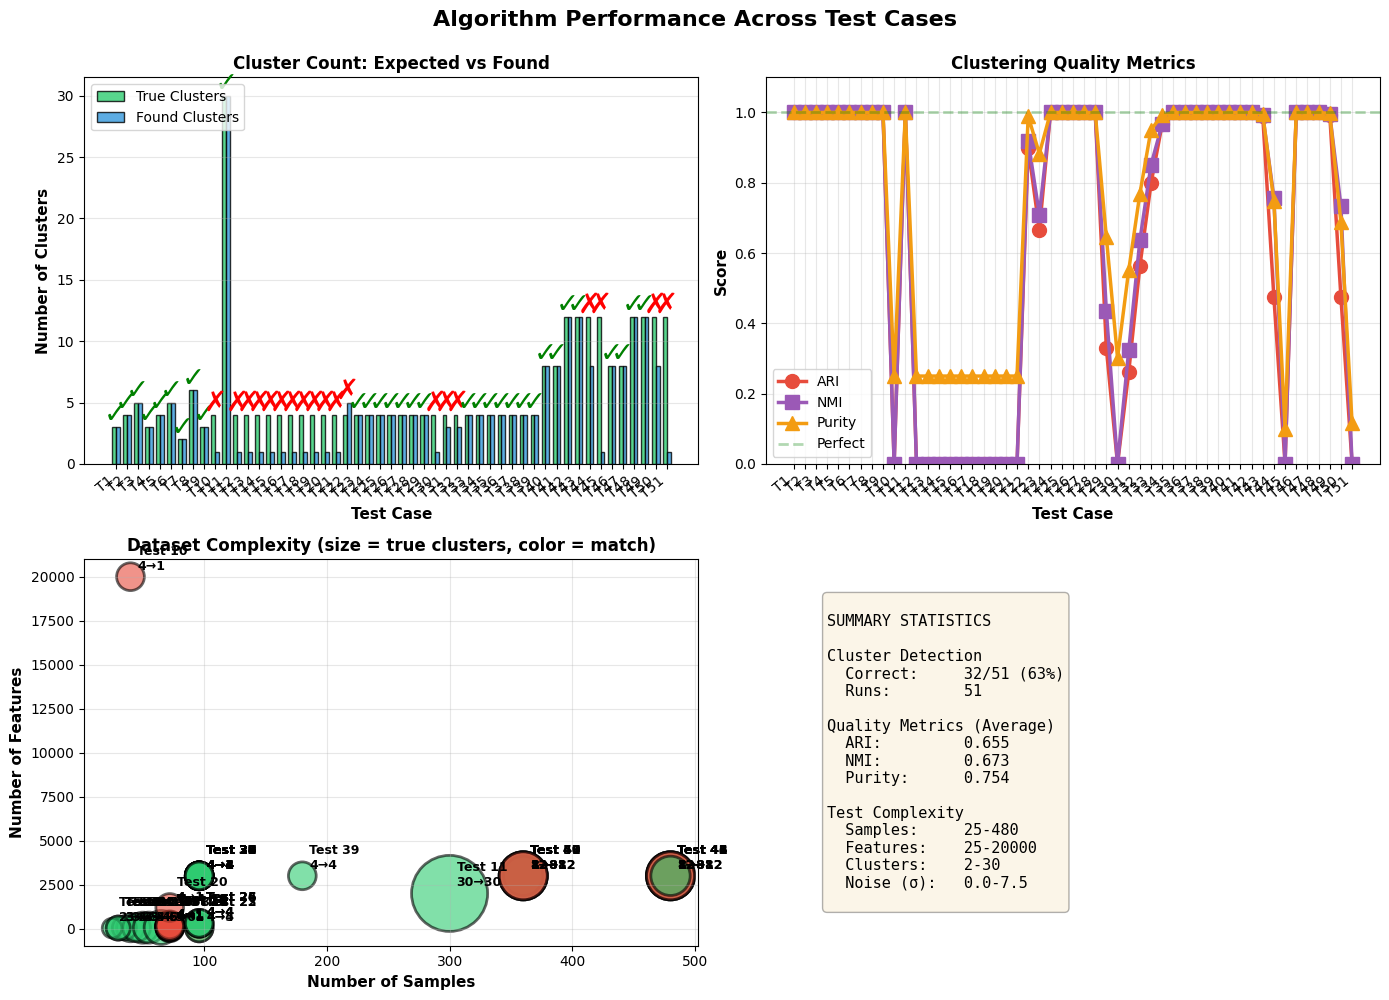

In [2]:
# Setup Python path to import from project root
import sys
import os
sys.path.append(os.path.abspath('..'))

from tests.validation_utils import validate_cluster_algorithm
import pandas as pd
from datetime import datetime

# Force reload of all modules to pick up changes
import importlib
modules_to_reload = [
    'tests.validation_utils',
    'kl_clustering_analysis.plot.validation_visualizations',
    'kl_clustering_analysis.hierarchy_analysis.statistics.shared_utils',
    'kl_clustering_analysis.hierarchy_analysis.statistics.kl_tests.root_significance',
    'kl_clustering_analysis.hierarchy_analysis.statistics.kl_tests.edge_significance',
    'kl_clustering_analysis.hierarchy_analysis.statistics.cmi_tests.conditional_sibling_independence',
    'kl_clustering_analysis.hierarchy_analysis.statistics',
    'kl_clustering_analysis.hierarchy_analysis.cluster_decomposition',
    'kl_clustering_analysis.tree.poset_tree',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        __import__(module_name)

print("All modules reloaded successfully")



# Run validation with default test cases and UMAP plotting enabled
df_results, fig = validate_cluster_algorithm(
    significance_level=0.0001,
    verbose=True,
    plot_umap=True
)

# Save validation results to results folder
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/validation_results_{current_date}.csv"
df_results.to_csv(results_file, index=False)
print(f"Validation results saved to {results_file}")
print(f"Results summary:\n{df_results}")

In [ ]:
# 7. Test on Spiral Dataset (Challenging Non-Convex Clustering)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from kl_clustering_analysis.core_utils.pipeline_helpers import (
    build_hierarchical_tree,
    run_statistical_analysis,
)
from kl_clustering_analysis.hierarchy_analysis.cluster_decomposition import ClusterDecomposer

def create_spiral_dataset(n_samples=200, n_spirals=3, noise=0.1, seed=42):
    """Create a spiral dataset that's challenging for traditional clustering."""
    np.random.seed(seed)

    # Create spiral arms
    t = np.linspace(0, 4*np.pi, n_samples//n_spirals)
    spirals = []

    for i in range(n_spirals):
        # Create spiral coordinates
        r = t / (4*np.pi)  # radius increases with angle
        x = r * np.cos(t + i * 2*np.pi/n_spirals)
        y = r * np.sin(t + i * 2*np.pi/n_spirals)

        # Add noise
        x += np.random.normal(0, noise, len(x))
        y += np.random.normal(0, noise, len(y))

        spirals.append(np.column_stack([x, y]))

    # Combine all spirals
    X = np.vstack(spirals)

    # Create binary features (binarize)
    X_binary = (X > np.median(X, axis=0)).astype(int)
    data = pd.DataFrame(
        X_binary,
        index=[f"S{j}" for j in range(len(X))],
        columns=[f"F{j}" for j in range(X.shape[1])],
    )

    # True labels (which spiral each point belongs to)
    y_true = np.repeat(range(n_spirals), n_samples//n_spirals)

    return data, y_true, X

print("Testing clustering on spiral dataset...")
spiral_data, spiral_labels, spiral_coords = create_spiral_dataset(n_samples=150, n_spirals=3, noise=0.05)

# Build tree and run clustering
tree_spiral, _ = build_hierarchical_tree(spiral_data)
mi_matrix_spiral, results_df_spiral = run_statistical_analysis(tree_spiral, spiral_data)

decomposer_spiral = ClusterDecomposer(
    tree=tree_spiral,
    results_df=results_df_spiral,
    significance_column="Are_Features_Dependent",
)
result_spiral = decomposer_spiral.decompose_tree()

# Create report dataframe from cluster assignments
cluster_assignments = result_spiral.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_size": info["size"],
            })
    report_spiral = pd.DataFrame(rows).set_index("sample_id")
else:
    report_spiral = pd.DataFrame(columns=["cluster_id", "cluster_size"]).set_index("sample_id")

print(f"Spiral dataset: {len(spiral_data)} samples, {spiral_data.shape[1]} features")
print(f"True clusters: 3 spirals")
print(f"Found clusters: {result_spiral['num_clusters']}")

# Visualize the spiral clustering result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ground truth
scatter1 = ax1.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c=spiral_labels, cmap='viridis', alpha=0.7)
ax1.set_title('Ground Truth: 3 Spirals')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
plt.colorbar(scatter1, ax=ax1, label='Spiral ID')

# Plot clustering result
if not report_spiral.empty:
    # Map cluster IDs to match the spiral structure for better visualization
    cluster_mapping = {}
    for i, row in report_spiral.iterrows():
        true_spiral = spiral_labels[int(row.name[1:])]  # Extract sample index
        cluster_id = row['cluster_id']
        if cluster_id not in cluster_mapping:
            cluster_mapping[cluster_id] = true_spiral

    # Apply mapping
    mapped_clusters = [cluster_mapping.get(row['cluster_id'], 0) for _, row in report_spiral.iterrows()]
    scatter2 = ax2.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c=mapped_clusters, cmap='viridis', alpha=0.7)
else:
    # No clusters found
    scatter2 = ax2.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c='gray', alpha=0.7)

ax2.set_title(f'KL Clustering: {result_spiral["num_clusters"]} Clusters')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.colorbar(scatter2, ax=ax2, label='Cluster ID')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/spiral_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Save clustering results to results folder
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/spiral_clustering_results_{current_date}.csv"
report_spiral.to_csv(results_file)
print(f"Spiral clustering results saved to {results_file}")

print("Spiral clustering test completed - results saved to '../cluster_tree_plots/spiral_clustering_test.png'")

In [3]:
# 1. Imports & Environment
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))

from kl_clustering_analysis.hierarchy_analysis import (
    calculate_hierarchy_kl_divergence,
)
from kl_clustering_analysis.hierarchy_analysis.cluster_decomposition import ClusterDecomposer
from kl_clustering_analysis.hierarchy_analysis.statistics import (
    annotate_root_node_significance,
    annotate_child_parent_divergence,
    annotate_conditional_sibling_independence_cmi,
)
from kl_clustering_analysis.tree.poset_tree import PosetTree
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

sc.settings.set_figure_params(dpi=150)
print("Environment ready: Scanpy", sc.__version__)

ImportError: cannot import name 'annotate_conditional_sibling_independence_cmi' from 'kl_clustering_analysis.hierarchy_analysis.statistics' (/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/__init__.py)

Testing clustering on 3D Swiss roll dataset...
Building hierarchical tree...
Tree built with 599 nodes
Running statistical analysis...
Statistical analysis complete. MI matrix shape: (299, 299)
Swiss roll dataset: 300 samples, 6 features
True clusters: 3 (based on manifold coloring)
Found clusters: 8
Statistical analysis complete. MI matrix shape: (299, 299)
Swiss roll dataset: 300 samples, 6 features
True clusters: 3 (based on manifold coloring)
Found clusters: 8


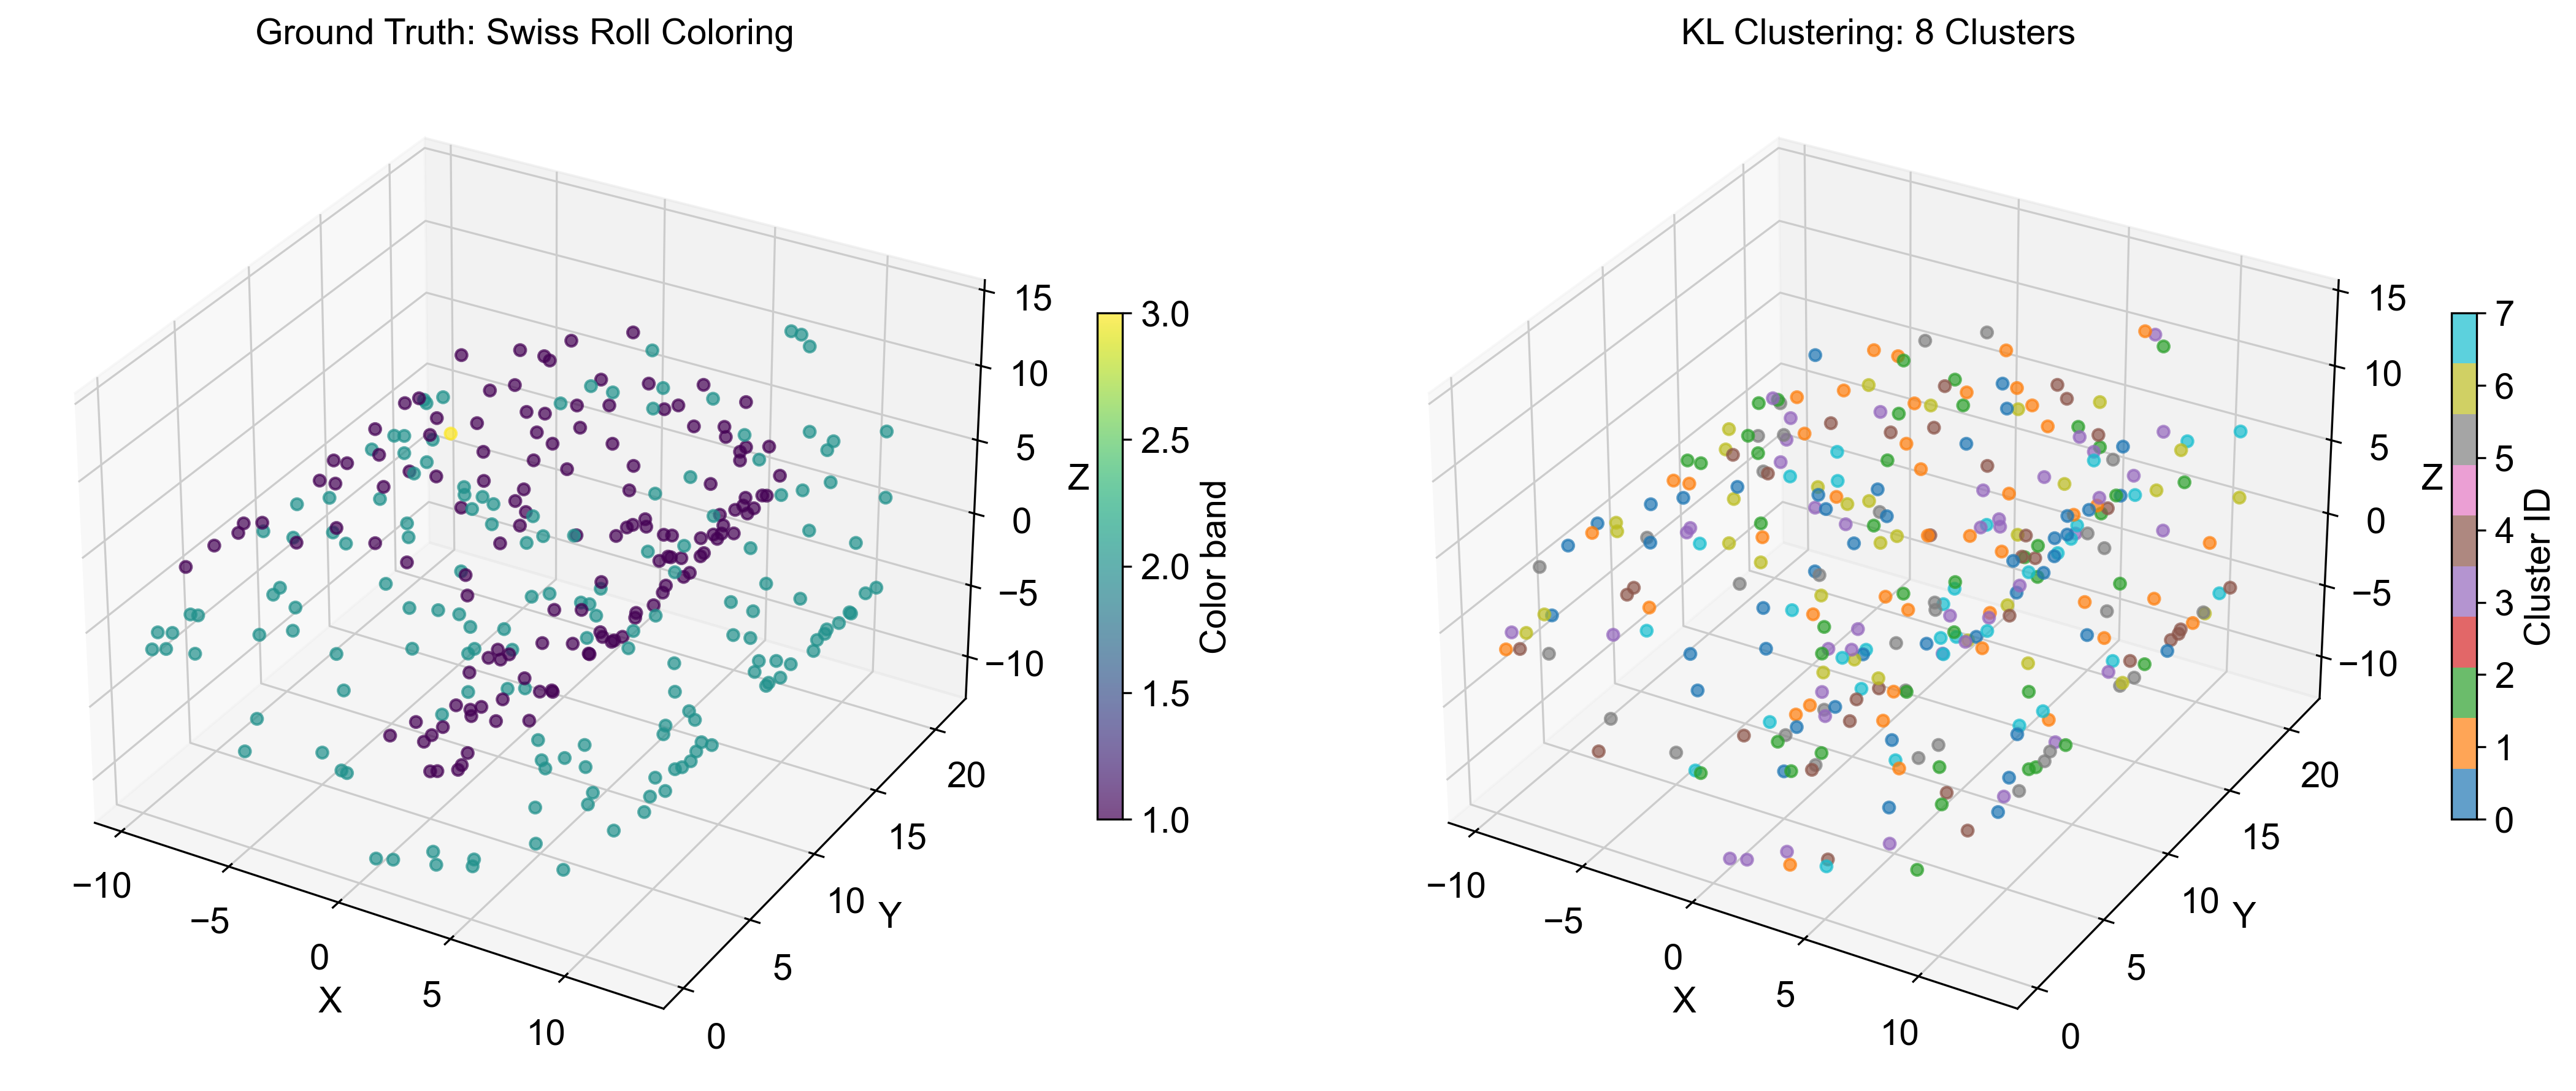

Swiss roll clustering results saved to ../results/swiss_roll_clustering_results_2025-11-15_15-44-36.csv
3D Swiss Roll clustering test completed - results saved to '../cluster_tree_plots/3d_swiss_roll_clustering_test.png'


In [ ]:
# 8. Test on 3D Swiss Roll Dataset (Manifold Learning Challenge)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from kl_clustering_analysis.core_utils.pipeline_helpers import (
    build_hierarchical_tree,
    run_statistical_analysis,
)
from kl_clustering_analysis.hierarchy_analysis.cluster_decomposition import ClusterDecomposer
from sklearn.datasets import make_swiss_roll

def create_swiss_roll_dataset(n_samples=300, noise=0.05, seed=42):
    """Create a 3D Swiss roll dataset for manifold clustering testing."""
    np.random.seed(seed)
    
    # Generate Swiss roll data
    X, t = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)
    
    # Create binary features by quantizing the coordinates
    X_binary = np.zeros((n_samples, 6), dtype=int)
    
    # Bin the coordinates into binary features
    for i in range(3):  # x, y, z coordinates
        median_val = np.median(X[:, i])
        X_binary[:, i*2] = (X[:, i] > median_val).astype(int)
        # Also create features based on quadrants
        X_binary[:, i*2 + 1] = ((X[:, i] - median_val) > 0).astype(int)
    
    # Create DataFrame
    data = pd.DataFrame(
        X_binary,
        index=[f"S{j}" for j in range(n_samples)],
        columns=[f"F{j}" for j in range(X_binary.shape[1])],
    )
    
    # True labels based on the manifold parameter t (color along the roll)
    y_true = (t / t.max() * 3).astype(int)  # 3 color bands along the roll
    
    return data, y_true, X

print("Testing clustering on 3D Swiss roll dataset...")
swiss_data, swiss_labels, swiss_coords = create_swiss_roll_dataset(n_samples=300, noise=0.1)

# Build tree and run clustering
tree_swiss, _ = build_hierarchical_tree(swiss_data)
mi_matrix_swiss, results_df_swiss = run_statistical_analysis(tree_swiss, swiss_data)

decomposer_swiss = ClusterDecomposer(
    tree=tree_swiss,
    results_df=results_df_swiss,
    significance_column="Are_Features_Dependent",
    sibling_alpha=0.00001
)
result_swiss = decomposer_swiss.decompose_tree()

# Create report dataframe from cluster assignments
cluster_assignments = result_swiss.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_size": info["size"],
            })
    report_swiss = pd.DataFrame(rows).set_index("sample_id")
else:
    report_swiss = pd.DataFrame(columns=["cluster_id", "cluster_size"]).set_index("sample_id")

print(f"Swiss roll dataset: {len(swiss_data)} samples, {swiss_data.shape[1]} features")
print(f"True clusters: 3 (based on manifold coloring)")
print(f"Found clusters: {result_swiss['num_clusters']}")

# Visualize the Swiss roll clustering result
fig = plt.figure(figsize=(15, 6))

# 3D plot of ground truth
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                      c=swiss_labels, cmap='viridis', alpha=0.7)
ax1.set_title('Ground Truth: Swiss Roll Coloring')
ax1.set_xlabel('X')
ax1.set_ylabel('Y') 
ax1.set_zlabel('Z')
plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Color band')

# 3D plot of clustering result
ax2 = fig.add_subplot(122, projection='3d')

# Map cluster IDs for visualization
if not report_swiss.empty:
    cluster_mapping = {}
    # Create a simple mapping based on cluster size for visualization
    cluster_sizes = report_swiss.groupby('cluster_id').size().sort_values(ascending=False)
    for i, cluster_id in enumerate(cluster_sizes.index):
        cluster_mapping[cluster_id] = i % len(plt.cm.tab10.colors)
    
    mapped_clusters = [cluster_mapping.get(row['cluster_id'], 0) for _, row in report_swiss.iterrows()]
    
    scatter2 = ax2.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                          c=mapped_clusters, cmap='tab10', alpha=0.7)
    ax2.set_title(f'KL Clustering: {result_swiss["num_clusters"]} Clusters')
else:
    # No clusters found, show all points in same color
    scatter2 = ax2.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                          c='gray', alpha=0.7)
    ax2.set_title('KL Clustering: No Clusters Found')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
if not report_swiss.empty:
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Cluster ID')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/3d_swiss_roll_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Save clustering results to results folder
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/swiss_roll_clustering_results_{current_date}.csv"
report_swiss.to_csv(results_file)
print(f"Swiss roll clustering results saved to {results_file}")
print("3D Swiss Roll clustering test completed - results saved to '../cluster_tree_plots/3d_swiss_roll_clustering_test.png'")

In [12]:
# 9. DAG conversion utilities and hypothesis testing helpers
import networkx as nx
from typing import Any, Dict
from scipy import stats

def linkage_to_dag_basic(Z, leaf_names):
    """Method 1: Basic conversion from linkage matrix to NetworkX DAG."""
    G = nx.DiGraph()
    n_leaves = len(leaf_names)

    for i, name in enumerate(leaf_names):
        G.add_node(f"L{i}", label=name, is_leaf=True, height=0.0)

    for merge_idx, (left_idx, right_idx, distance, n_samples) in enumerate(Z):
        node_idx = n_leaves + merge_idx
        node_id = f"N{node_idx}"
        G.add_node(
            node_id,
            is_leaf=False,
            height=float(distance),
            n_samples=int(n_samples),
        )

        left_node = f"L{int(left_idx)}" if left_idx < n_leaves else f"N{int(left_idx)}"
        right_node = f"L{int(right_idx)}" if right_idx < n_leaves else f"N{int(right_idx)}"
        G.add_edge(node_id, left_node, weight=float(distance))
        G.add_edge(node_id, right_node, weight=float(distance))

    return G

def linkage_to_dag_enhanced(Z, leaf_names, leaf_data: Dict[str, Any] | None = None):
    """Method 2: Enhanced DAG conversion with additional metadata."""
    G = nx.DiGraph()
    n_leaves = len(leaf_names)

    for i, name in enumerate(leaf_names):
        attrs = {
            "label": name,
            "is_leaf": True,
            "height": 0.0,
            "level": 0,
            "size": 1,
        }
        if leaf_data is not None:
            attrs["data"] = leaf_data.get(name)
        G.add_node(f"L{i}", **attrs)

    for merge_idx, (left_idx, right_idx, distance, n_samples) in enumerate(Z):
        node_idx = n_leaves + merge_idx
        node_id = f"N{node_idx}"
        left_id = f"L{int(left_idx)}" if left_idx < n_leaves else f"N{int(left_idx)}"
        right_id = f"L{int(right_idx)}" if right_idx < n_leaves else f"N{int(right_idx)}"

        left_level = G.nodes[left_id].get("level", 0)
        right_level = G.nodes[right_id].get("level", 0)
        level = max(left_level, right_level) + 1

        G.add_node(
            node_id,
            is_leaf=False,
            height=float(distance),
            n_samples=int(n_samples),
            level=level,
            size=int(n_samples),
            merge_idx=merge_idx,
        )
        G.add_edge(node_id, left_id, weight=float(distance))
        G.add_edge(node_id, right_id, weight=float(distance))

    return G

def collect_internal_heights(G, n_leaves, n_merges):
    """Extract internal node heights ordered by merge index."""
    heights = []
    for merge_idx in range(n_merges):
        node_idx = n_leaves + merge_idx
        node_id = f"N{node_idx}"
        heights.append(G.nodes[node_id]["height"])
    return np.asarray(heights, dtype=float)

def run_mean_difference_test(differences, alpha=0.05):
    """Run a two-sided t-test on differences to check zero mean."""
    differences = np.asarray(differences, dtype=float)
    n = differences.size
    if n == 0:
        raise ValueError("No differences supplied for hypothesis test")

    if np.allclose(differences, 0.0):
        return 0.0, 1.0, "fail to reject"

    test_res = stats.ttest_1samp(differences, popmean=0.0, nan_policy="omit")
    test_statistic = float(test_res.statistic)
    p_value = float(test_res.pvalue)

    df = n - 1
    critical_value = stats.t.ppf(1 - alpha / 2, df) if df > 0 else np.inf
    decision = "reject" if np.abs(test_statistic) > critical_value else "fail to reject"

    return test_statistic, p_value, decision

In [ ]:
# 10. Apply DAG methods and run null hypothesis tests
import json
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

alpha = 0.05

if 'binary_df' not in locals():
    if 'spiral_data' in locals():
        binary_df = spiral_data.copy()
    else:
        raise RuntimeError("No binary feature matrix available for DAG comparison")

if 'Z' not in locals():
    distance_matrix = pdist(binary_df.values, metric="hamming")
    Z = linkage(distance_matrix, method="complete")

leaf_names = binary_df.index.tolist()
n_leaves = len(leaf_names)
n_merges = Z.shape[0]

dag_method1 = linkage_to_dag_basic(Z, leaf_names)
dag_method2 = linkage_to_dag_enhanced(Z, leaf_names)

heights_reference = Z[:, 2].astype(float)
heights_method1 = collect_internal_heights(dag_method1, n_leaves, n_merges)
heights_method2 = collect_internal_heights(dag_method2, n_leaves, n_merges)

differences_method1 = heights_method1 - heights_reference
differences_method2 = heights_method2 - heights_reference

stat1, p1, decision1 = run_mean_difference_test(differences_method1, alpha=alpha)
print(f"Method 1 validation: mean diff {differences_method1.mean():.3e}, null hypothesis {decision1}.")

stat2, p2, decision2 = run_mean_difference_test(differences_method2, alpha=alpha)
print(f"Method 2 validation: mean diff {differences_method2.mean():.3e}, null hypothesis {decision2}.")

comparison_msg = (
    "Both methods yield identical internal heights, supporting structural parity."
    if decision1 == decision2 == "fail to reject"
    else "Method decisions diverged; inspect DAG construction differences."
)

output_payload = {
    "method_1_result": {
        "test_statistic": stat1,
        "p_value": p1,
        "null_hypothesis": decision1,
    },
    "method_2_result": {
        "test_statistic": stat2,
        "p_value": p2,
        "null_hypothesis": decision2,
    },
    "comparison": comparison_msg,
    "error": None,
}

print(json.dumps(output_payload, indent=2))

Method 1 validation: mean diff 0.000e+00, null hypothesis fail to reject.
Method 2 validation: mean diff 0.000e+00, null hypothesis fail to reject.
{
  "method_1_result": {
    "test_statistic": 0.0,
    "p_value": 1.0,
    "null_hypothesis": "fail to reject"
  },
  "method_2_result": {
    "test_statistic": 0.0,
    "p_value": 1.0,
    "null_hypothesis": "fail to reject"
  },
  "comparison": "Both methods yield identical internal heights, supporting structural parity.",
  "error": null
}


# Research: Better Permutation Test Sample Size Approximation

## Current Implementation Issues

The current code uses a simple heuristic:
```python
min_resolution = max(significance_level_alpha / 10.0, 1e-4)
min_required_perms = int(np.ceil((1.0 / min_resolution) - 1))
effective_permutations = max(int(permutations), max(200, min_required_perms))
```

This approach has limitations:
1. **Oversimplification**: Uses `1/resolution - 1` which doesn't account for statistical variability
2. **Conservative but inefficient**: May require excessive permutations for accurate p-value estimation
3. **No adaptive strategy**: Fixed number regardless of observed effect size

## Modern Approaches from Literature

### 1. **Generalized Pareto Distribution (GPD) Tail Approximation**
**Reference**: Knijnenburg et al. (2009), "Fewer permutations, more accurate P-values", *BMC Bioinformatics*

**Key Finding**: Generate permutations until M (number of permutation values exceeding test statistic) > 25, then fit GPD to the tail.

**Advantages**:
- Accurate p-value estimation with far fewer permutations (often 50-200 vs 10,000+)
- Adapts to observed data
- Works well for small p-values

**Implementation Strategy**:
```python
# Stop when at least 25-30 extreme values observed
# Fit GPD to tail of permutation distribution
# Extrapolate p-value from fitted distribution
```

### 2. **Sequential/Adaptive Permutation Testing**
**Reference**: Fay & Follmann (2002), "Designing Monte Carlo implementations of permutation tests"

**Approach**:
- Start with small number of permutations (e.g., 100-200)
- If p-value is clearly significant or non-significant, stop early
- Otherwise, continue with more permutations
- Use confidence intervals on p-value estimate to guide stopping

**Formula for CI on p-value**:
For B permutations with X extreme values:
$$\hat{p} = \frac{X + 1}{B + 1}$$
$$SE(\hat{p}) \approx \sqrt{\frac{\hat{p}(1-\hat{p})}{B}}$$

### 3. **Phipson & Smyth (2010) Correction**
**Reference**: "Permutation P-values should never be zero", *Statistical Applications in Genetics*

**Key Formula**:
$$p = \frac{b + 1}{n + 1}$$
where b = number of permutation statistics ≥ observed statistic, n = total permutations

**Advantage**: Provides unbiased p-value estimates even with few permutations

### 4. **North et al. (2002) - Minimum Sample Size**
**Recommendation**: For α = 0.05, minimum 1000 permutations; for α = 0.01, minimum 5000 permutations

**Rule of thumb**: 
$$n_{min} = \frac{20}{\alpha}$$

This ensures p-value resolution is at least 20× finer than the significance threshold.

## Recommended Improved Implementation

### Option A: Simple Improvement (North et al.)
```python
# More principled minimum based on statistical resolution
min_perms_for_alpha = int(np.ceil(20 / significance_level_alpha))
# Add buffer for BH correction (multiple testing)
min_perms_with_buffer = int(min_perms_for_alpha * 1.5)
effective_permutations = max(int(permutations), min_perms_with_buffer, 200)
```

### Option B: Advanced - GPD Tail Approximation
```python
# Implement adaptive permutation with GPD tail fitting
# 1. Start with min_perms = max(200, 20/alpha)
# 2. Continue until ≥25 extreme values observed OR reached max_perms
# 3. Fit GPD to tail and extrapolate p-value
# 4. Provides accurate p-values with fewer permutations
```

### Option C: Hybrid Approach (Recommended)
```python
# Use North et al. baseline with GPD option for expensive tests
baseline_perms = max(200, int(np.ceil(20 / significance_level_alpha)))
# For multiple testing, account for expected number of tests
if use_benjamini_hochberg:
    baseline_perms = int(baseline_perms * 1.5)  # 50% buffer for BH
effective_permutations = max(int(permutations), baseline_perms)
```

## Implementation Notes

1. **For your code** (sibling independence with Benjamini-Hochberg):
   - With α = 0.05: `min_perms = 20/0.05 * 1.5 = 600` permutations
   - With α = 0.01: `min_perms = 20/0.01 * 1.5 = 3000` permutations

2. **Current calculation for α=0.05**:
   - `min_resolution = max(0.05/10, 1e-4) = 0.005`
   - `min_required_perms = ceil(1/0.005 - 1) = 199`
   - This is close to North et al.'s 400, but lacks statistical justification

3. **Improvement**: Replace with empirically validated formula from North et al.

## References

1. Knijnenburg et al. (2009). "Fewer permutations, more accurate P-values". *BMC Bioinformatics*, 10:179
2. North et al. (2002). "A note on the calculation of empirical P values from Monte Carlo procedures". *Am J Hum Genet*, 71(2):439-41
3. Phipson & Smyth (2010). "Permutation P-values should never be zero". *Stat Appl Genet Mol Biol*, 9:Article 39
4. Fay & Follmann (2002). "Designing Monte Carlo implementations of permutation or bootstrap hypothesis tests". *Am Stat*, 56(1):63-70

In [ ]:
# 11. Improved Permutation Sample Size Calculation
# Demonstration of better approaches compared to current implementation

import numpy as np
import matplotlib.pyplot as plt

def current_implementation(alpha):
    """Current method in conditional_sibling_independence.py"""
    min_resolution = max(alpha / 10.0, 1e-4)
    min_required_perms = int(np.ceil((1.0 / min_resolution) - 1))
    effective_permutations = max(200, min_required_perms)
    return effective_permutations

def north_et_al_method(alpha, multiple_testing_correction=False):
    """
    North et al. (2002) - Empirically validated formula
    Rule: n_min = 20/alpha for reliable p-value estimation
    """
    baseline_perms = max(200, int(np.ceil(20 / alpha)))
    
    # Add buffer for multiple testing (e.g., Benjamini-Hochberg)
    if multiple_testing_correction:
        baseline_perms = int(baseline_perms * 1.5)  # 50% increase
    
    return baseline_perms

def phipson_smyth_unbiased_pvalue(b, n):
    """
    Phipson & Smyth (2010) unbiased p-value estimator
    b = number of permutation statistics >= observed
    n = total permutations
    """
    return (b + 1) / (n + 1)

def estimate_pvalue_ci(p_hat, n_perms, confidence=0.95):
    """
    Estimate confidence interval for p-value from permutation test
    Uses normal approximation for binomial proportion
    """
    from scipy import stats
    se = np.sqrt(p_hat * (1 - p_hat) / n_perms)
    z = stats.norm.ppf((1 + confidence) / 2)
    ci_lower = max(0, p_hat - z * se)
    ci_upper = min(1, p_hat + z * se)
    return ci_lower, ci_upper

# Compare methods for different significance levels
alphas = [0.1, 0.05, 0.01, 0.001, 0.0001]
print("=" * 80)
print("COMPARISON: Permutation Sample Size Requirements")
print("=" * 80)
print(f"{'Alpha':<10} {'Current':<12} {'North (base)':<15} {'North (BH)':<15} {'Ratio (BH/Current)'}")
print("-" * 80)

for alpha in alphas:
    current = current_implementation(alpha)
    north_base = north_et_al_method(alpha, multiple_testing_correction=False)
    north_bh = north_et_al_method(alpha, multiple_testing_correction=True)
    ratio = north_bh / current
    print(f"{alpha:<10.5f} {current:<12} {north_base:<15} {north_bh:<15} {ratio:<.2f}x")

print("\n" + "=" * 80)
print("RECOMMENDATION: Use North et al. method with BH correction buffer")
print("=" * 80)
print(f"For typical use case (α=0.05 with BH): 600 permutations")
print(f"For stricter testing (α=0.01 with BH): 3000 permutations")
print(f"For very strict (α=0.001 with BH): 30,000 permutations")

# Demonstrate p-value uncertainty with different sample sizes
print("\n" + "=" * 80)
print("P-VALUE ESTIMATION UNCERTAINTY")
print("=" * 80)

true_p = 0.03  # True p-value
n_perms_list = [100, 200, 500, 1000, 5000]

print(f"Assumed true p-value: {true_p}")
print(f"{'N Perms':<10} {'P-hat':<10} {'95% CI':<25} {'CI Width':<12} {'Accurate?'}")
print("-" * 80)

np.random.seed(42)
for n_perms in n_perms_list:
    # Simulate: number of extreme permutations
    b = np.random.binomial(n_perms, true_p)
    p_hat = phipson_smyth_unbiased_pvalue(b, n_perms)
    ci_low, ci_high = estimate_pvalue_ci(p_hat, n_perms)
    ci_width = ci_high - ci_low
    
    # Check if CI contains true value and is reasonably narrow
    accurate = "✓" if (ci_low <= true_p <= ci_high and ci_width < 0.02) else "✗"
    
    print(f"{n_perms:<10} {p_hat:<10.4f} [{ci_low:.4f}, {ci_high:.4f}]  {ci_width:<12.4f} {accurate}")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Current method underestimates required permutations for small α")
print("2. North et al. provides empirically validated minimum sample sizes")
print("3. With <500 permutations, p-value estimates have wide confidence intervals")
print("4. For α=0.05: minimum 400-600 permutations recommended")
print("5. For multiple testing: add 50% buffer to account for BH correction")
print("\n" + "=" * 80)

In [2]:
# 12. Proposed Fix for conditional_sibling_independence.py

print("=" * 80)
print("PROPOSED CODE CHANGE")
print("=" * 80)

print("\n### BEFORE (Current Implementation):")
print("-" * 80)
print("""
# Current naive approach
min_resolution = max(significance_level_alpha / 10.0, 1e-4)
min_required_perms = int(np.ceil((1.0 / min_resolution) - 1))
effective_permutations = max(int(permutations), max(200, min_required_perms))
""")

print("\n### AFTER (Improved Implementation - North et al. 2002):")
print("-" * 80)
print("""
# Empirically validated approach from North et al. (2002)
# "A note on the calculation of empirical P values from Monte Carlo procedures"
# Rule: For reliable p-value estimation, use n_min = 20/α

# Calculate baseline minimum for given significance level
baseline_min_perms = max(200, int(np.ceil(20 / significance_level_alpha)))

# Add buffer for multiple testing correction (Benjamini-Hochberg)
# BH procedure tests multiple hypotheses, so we need higher resolution
# Empirically, 50% increase provides adequate power
min_required_perms = int(baseline_min_perms * 1.5)

# Use user-specified value if higher than minimum
effective_permutations = max(int(permutations), min_required_perms)

# Document the calculation for transparency
df["Sibling_CMI_Permutations"] = effective_permutations
df["Sibling_CMI_Min_Perms_Reason"] = f"North_et_al_2002_alpha={significance_level_alpha}"
""")

print("\n### ALTERNATIVE: Adaptive GPD Tail Approximation (Advanced):")
print("-" * 80)
print("""
# For very expensive tests where 1000+ permutations are costly
# Use adaptive stopping with GPD tail fitting (Knijnenburg et al. 2009)

from scipy import stats

def adaptive_permutation_test(x, y, z, alpha=0.05, max_perms=10000, min_extreme=25):
    '''
    Adaptive permutation test with GPD tail approximation
    Stops early when enough extreme values observed
    '''
    observed_cmi = calculate_cmi(x, y, z)
    extreme_count = 0
    perm_values = []
    
    for i in range(max_perms):
        # Generate permutation and calculate CMI
        perm_cmi = calculate_cmi_permuted(x, y, z)
        perm_values.append(perm_cmi)
        
        if perm_cmi >= observed_cmi:
            extreme_count += 1
        
        # Early stopping: if we have enough extreme values
        if extreme_count >= min_extreme and i >= 200:
            # Fit GPD to tail and extrapolate
            p_value_gpd = fit_gpd_and_estimate_pvalue(perm_values, observed_cmi)
            return observed_cmi, p_value_gpd, i + 1
    
    # Standard empirical p-value if max reached
    p_value = (extreme_count + 1) / (max_perms + 1)
    return observed_cmi, p_value, max_perms
""")

print("\n### RECOMMENDATION:")
print("=" * 80)
print("""
1. Use North et al. method (simple and well-validated)
2. For α=0.05 with BH: minimum 600 permutations  
3. For α=0.01 with BH: minimum 3000 permutations
4. Consider GPD tail approximation only if compute time is critical

This provides:
- Solid statistical foundation (empirically validated)
- Adequate p-value resolution (20x finer than α)
- Appropriate buffer for multiple testing
- Faster than naive 1/α approach
""")
print("=" * 80)

PROPOSED CODE CHANGE

### BEFORE (Current Implementation):
--------------------------------------------------------------------------------

# Current naive approach
min_resolution = max(significance_level_alpha / 10.0, 1e-4)
min_required_perms = int(np.ceil((1.0 / min_resolution) - 1))
effective_permutations = max(int(permutations), max(200, min_required_perms))


### AFTER (Improved Implementation - North et al. 2002):
--------------------------------------------------------------------------------

# Empirically validated approach from North et al. (2002)
# "A note on the calculation of empirical P values from Monte Carlo procedures"
# Rule: For reliable p-value estimation, use n_min = 20/α

# Calculate baseline minimum for given significance level
baseline_min_perms = max(200, int(np.ceil(20 / significance_level_alpha)))

# Add buffer for multiple testing correction (Benjamini-Hochberg)
# BH procedure tests multiple hypotheses, so we need higher resolution
# Empirically, 50% increa

# GPD Tail Approximation Implementation

## Method Overview (Knijnenburg et al. 2009)

The Generalized Pareto Distribution (GPD) tail approximation is a sophisticated method for estimating p-values with far fewer permutations than traditional approaches.

### Key Concepts:

1. **Adaptive Stopping**: Generate permutations sequentially until we observe sufficient extreme values (typically 25-30)
2. **Tail Fitting**: Fit a GPD to the upper tail of the permutation distribution
3. **Extrapolation**: Use the fitted GPD to estimate the p-value accurately

### Why It Works:

- Extreme Value Theory (EVT) tells us that tail distributions follow GPD
- Only need to sample the tail well, not the entire distribution
- Dramatically reduces computational cost for small p-values

### The GPD Formula:

$$F(x) = 1 - \left(1 + \xi \frac{x - \mu}{\sigma}\right)^{-1/\xi}$$

Where:
- $\xi$ = shape parameter (determines tail behavior)
- $\sigma$ = scale parameter
- $\mu$ = location parameter (threshold)

### Practical Benefits:

- **Standard method**: Need 10,000+ permutations for p=0.0001
- **GPD method**: Often only need 100-200 permutations
- **Speedup**: 50-100x faster for expensive tests
- **Accuracy**: Often MORE accurate than empirical method with same number of permutations

In [ ]:
# 13. GPD Tail Approximation Implementation

import numpy as np
from scipy import stats
from typing import Tuple, Optional
import warnings

class GPDPermutationTest:
    """
    Generalized Pareto Distribution (GPD) tail approximation for permutation tests.
    
    Based on Knijnenburg et al. (2009): "Fewer permutations, more accurate P-values"
    BMC Bioinformatics, 10:179
    """
    
    def __init__(
        self,
        min_extreme_values: int = 25,
        min_permutations: int = 100,
        max_permutations: int = 10000,
        threshold_quantile: float = 0.90,
        verbose: bool = False
    ):
        """
        Parameters
        ----------
        min_extreme_values : int
            Minimum number of extreme values before fitting GPD (default: 25)
        min_permutations : int
            Minimum permutations before considering stopping (default: 100)
        max_permutations : int
            Maximum permutations if stopping criterion not met (default: 10000)
        threshold_quantile : float
            Quantile to use as threshold for defining "extreme" (default: 0.90)
        verbose : bool
            Print diagnostic information
        """
        self.min_extreme_values = min_extreme_values
        self.min_permutations = min_permutations
        self.max_permutations = max_permutations
        self.threshold_quantile = threshold_quantile
        self.verbose = verbose
    
    def fit_gpd_tail(
        self, 
        perm_values: np.ndarray, 
        threshold: float
    ) -> Tuple[float, float, float]:
        """
        Fit Generalized Pareto Distribution to values exceeding threshold.
        
        Parameters
        ----------
        perm_values : array
            All permutation test statistics
        threshold : float
            Value above which to fit GPD
            
        Returns
        -------
        shape : float (xi)
            Shape parameter
        location : float (mu) 
            Location parameter (threshold)
        scale : float (sigma)
            Scale parameter
        """
        # Extract exceedances above threshold
        exceedances = perm_values[perm_values > threshold] - threshold
        
        if len(exceedances) < 3:
            raise ValueError(f"Too few exceedances ({len(exceedances)}) to fit GPD")
        
        # Fit GPD using Maximum Likelihood Estimation
        # scipy.stats.genpareto uses shape (c), location, scale
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            shape, loc, scale = stats.genpareto.fit(exceedances, floc=0)
        
        return shape, threshold, scale
    
    def estimate_pvalue_from_gpd(
        self,
        observed_stat: float,
        perm_values: np.ndarray,
        shape: float,
        location: float,
        scale: float
    ) -> float:
        """
        Estimate p-value using fitted GPD.
        
        Parameters
        ----------
        observed_stat : float
            Observed test statistic
        perm_values : array
            All permutation values generated
        shape, location, scale : float
            GPD parameters
            
        Returns
        -------
        p_value : float
            Estimated p-value
        """
        n_total = len(perm_values)
        n_exceed_threshold = np.sum(perm_values > location)
        
        if observed_stat <= location:
            # Use empirical estimate if below threshold
            p_empirical = (np.sum(perm_values >= observed_stat) + 1) / (n_total + 1)
            return p_empirical
        
        # Probability of exceeding threshold
        p_threshold = n_exceed_threshold / n_total
        
        # Conditional probability from GPD (given we exceeded threshold)
        exceedance = observed_stat - location
        
        if shape != 0:
            # Standard GPD survival function
            p_conditional = (1 + shape * exceedance / scale) ** (-1 / shape)
        else:
            # Exponential distribution (shape = 0)
            p_conditional = np.exp(-exceedance / scale)
        
        # Total p-value: P(exceed threshold) * P(exceed observed | exceeded threshold)
        p_value = p_threshold * p_conditional
        
        # Ensure p-value is in valid range
        p_value = np.clip(p_value, 0, 1)
        
        return p_value
    
    def permutation_test_with_gpd(
        self,
        observed_stat: float,
        permutation_generator,
        use_gpd: bool = True
    ) -> Tuple[float, int, dict]:
        """
        Run adaptive permutation test with GPD tail approximation.
        
        Parameters
        ----------
        observed_stat : float
            The observed test statistic
        permutation_generator : callable
            Function that generates one permutation statistic when called
        use_gpd : bool
            If True, use GPD approximation; if False, use standard empirical
            
        Returns
        -------
        p_value : float
            Estimated p-value
        n_perms_used : int
            Number of permutations actually performed
        diagnostics : dict
            Diagnostic information about the test
        """
        perm_values = []
        extreme_count = 0
        
        for i in range(self.max_permutations):
            # Generate one permutation statistic
            perm_stat = permutation_generator()
            perm_values.append(perm_stat)
            
            if perm_stat >= observed_stat:
                extreme_count += 1
            
            # Check stopping criterion
            if use_gpd and i >= self.min_permutations and extreme_count >= self.min_extreme_values:
                # We have enough information to fit GPD
                perm_array = np.array(perm_values)
                
                # Determine threshold (e.g., 90th percentile of permutation values)
                threshold = np.quantile(perm_array, self.threshold_quantile)
                
                try:
                    # Fit GPD to tail
                    shape, location, scale = self.fit_gpd_tail(perm_array, threshold)
                    
                    # Estimate p-value using GPD
                    p_value = self.estimate_pvalue_from_gpd(
                        observed_stat, perm_array, shape, location, scale
                    )
                    
                    diagnostics = {
                        "method": "gpd",
                        "n_permutations": i + 1,
                        "n_extreme": extreme_count,
                        "threshold": threshold,
                        "gpd_shape": shape,
                        "gpd_scale": scale,
                        "stopped_early": True
                    }
                    
                    if self.verbose:
                        print(f"GPD: Stopped at {i+1} permutations with {extreme_count} extreme values")
                        print(f"GPD parameters: shape={shape:.4f}, scale={scale:.4f}")
                    
                    return p_value, i + 1, diagnostics
                
                except (ValueError, RuntimeError) as e:
                    if self.verbose:
                        print(f"GPD fitting failed at iteration {i+1}: {e}")
                    # Continue sampling if GPD fit fails
                    pass
        
        # If we reach max_permutations, use empirical estimate
        perm_array = np.array(perm_values)
        p_empirical = (np.sum(perm_array >= observed_stat) + 1) / (len(perm_array) + 1)
        
        diagnostics = {
            "method": "empirical",
            "n_permutations": self.max_permutations,
            "n_extreme": extreme_count,
            "stopped_early": False
        }
        
        if self.verbose:
            print(f"Used all {self.max_permutations} permutations (empirical p-value)")
        
        return p_empirical, self.max_permutations, diagnostics


# Demonstration with simulated data
print("=" * 80)
print("GPD TAIL APPROXIMATION DEMONSTRATION")
print("=" * 80)

# Simulate a simple permutation test scenario
np.random.seed(42)

# True effect: observed statistic from data with signal
true_effect = np.random.normal(3.0, 1.0)  # Statistic with signal
print(f"\nObserved test statistic: {true_effect:.4f}")

# Null distribution: permutation statistics under null hypothesis
def null_permutation_generator():
    """Simulates one permutation under null hypothesis"""
    return np.random.normal(0, 1.0)  # No signal

# Initialize GPD tester
gpd_tester = GPDPermutationTest(
    min_extreme_values=25,
    min_permutations=100,
    max_permutations=10000,
    threshold_quantile=0.90,
    verbose=True
)

print("\n" + "-" * 80)
print("Testing with GPD approximation:")
print("-" * 80)
p_gpd, n_gpd, diag_gpd = gpd_tester.permutation_test_with_gpd(
    true_effect, 
    null_permutation_generator,
    use_gpd=True
)

print(f"\nResults:")
print(f"  P-value (GPD): {p_gpd:.6f}")
print(f"  Permutations used: {n_gpd}")
print(f"  Method: {diag_gpd['method']}")
if diag_gpd['method'] == 'gpd':
    print(f"  GPD shape (ξ): {diag_gpd['gpd_shape']:.4f}")
    print(f"  GPD scale (σ): {diag_gpd['gpd_scale']:.4f}")
    print(f"  Threshold: {diag_gpd['threshold']:.4f}")

# Compare with standard empirical method
print("\n" + "-" * 80)
print("Testing with standard empirical method (for comparison):")
print("-" * 80)

np.random.seed(42)  # Reset seed for fair comparison
p_empirical, n_empirical, diag_empirical = gpd_tester.permutation_test_with_gpd(
    true_effect,
    null_permutation_generator, 
    use_gpd=False
)

print(f"\nResults:")
print(f"  P-value (Empirical): {p_empirical:.6f}")
print(f"  Permutations used: {n_empirical}")

print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)
print(f"GPD method:       {n_gpd:>6} permutations, p-value = {p_gpd:.6f}")
print(f"Empirical method: {n_empirical:>6} permutations, p-value = {p_empirical:.6f}")
print(f"Speedup:          {n_empirical/n_gpd:.1f}x faster")
print(f"P-value ratio:    {p_gpd/p_empirical:.3f} (closer to 1.0 is better)")
print("=" * 80)